# Fermion parity switches imprinted in the photonic field of cavity embedded Kitaev chains

In this notebook we plot figures 2, 5, 6, 7 and 14 of the manuscript entitled ``[Fermion parity switches imprinted in the photonic field of cavity embedded Kitaev chains](https://arxiv.org/abs/2506.06237)''.  

In [1]:
import numpy as np
import h5py
import itertools
import matplotlib.pyplot as plt

from math import factorial
from math import comb
from math import prod

from scipy.sparse import eye, coo_array, bmat

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": "11.0"
})

In [3]:
def v_ocup_indx(occup):

    block_dim = comb(n_sites,occup)
    
    v = np.zeros((block_dim,n_sites), dtype=np.int8)
    sites_array = [ii for ii in range(n_sites)]

    nn = 0
    for indxs in itertools.combinations(sites_array,occup):
        for ll in indxs:
            v[nn,ll] = 1
            
        nn += 1
        
    return v

In [4]:
def c_op_fer(at):

    row = []
    column = []
    value = []
    offset = 0
    for oo in range(n_sites):
        v_blocks = v_ocup_indx(oo)
        w_blocks = v_ocup_indx(oo+1)
        v_indx = np.where(v_blocks[::,at] == 0) 
        #print(v_indx)
        red_b = []
        for ii in range(len(v_indx[0][::])):
            #print(ii)
            red_b.append(v_blocks[v_indx[0][ii],:])

        r_blocks = np.array(red_b)
        #print(r_blocks)
        r_blocks[::,at] = 1
        #print(r_blocks)
        for ii in range(len(v_indx[0][::])):
            for jj in range(len(w_blocks[::,0])):
                diff = r_blocks[ii,::] - w_blocks[jj,::]
                if np.dot(diff,diff) == 0:
                    #print('eureka:',jj,v_indx[0][ii])
                    row.append(jj+offset+len(v_blocks[::,0]))
                    stringel = (-1)**w_blocks[jj,:at:]
                    #print('string',stringel)
                    column.append(offset+v_indx[0][ii])
                    value.append(prod(stringel))
                    #value.append(1)

        offset += len(v_blocks[::,0])
        
    return coo_array((value,(row, column)), shape=(2**n_sites,2**n_sites))

In [5]:
def st_enlarge(gnd,parity):

    if parity == 'even':
        oi = 0
        vblocks = []
        offset = 0
            
        for oo in range(oi,n_sites,2):
            m_sect = int(factorial(n_sites)/factorial(oo)/factorial(n_sites-oo))
            n_nextsect = int(factorial(n_sites)/factorial(oo+1)/factorial(n_sites-oo-1))
            #print(m_sect,n_nextsect)
            zerofill = np.zeros(n_nextsect)
            vblocks.append(gnd[offset:offset+m_sect:])
            vblocks.append(zerofill)
            offset += m_sect
        if n_sites % 2 == 0:
            vblocks.append([gnd[-1]])
            
    elif parity == 'odd':
        oi = 1
        vblocks = []
        offset = 0
        for oo in range(oi,n_sites+1,2):
            l_prevsect = int(factorial(n_sites)/factorial(oo-1)/factorial(n_sites-oo+1))
            m_sect = int(factorial(n_sites)/factorial(oo)/factorial(n_sites-oo))
            #print(l_prevsect,m_sect)
            zerofill = np.zeros(l_prevsect)
            vblocks.append(zerofill)
            vblocks.append(gnd[offset:offset+m_sect:])
            offset += m_sect
            
        if n_sites % 2 == 0:
            vblocks.append(np.zeros(1))

    return np.concatenate(vblocks, axis=0)

In [6]:
n_sites = 11
list_c_op = [c_op_fer(jj) for jj in range(n_sites)]

def majo_dens(gnd_l,par_l,gnd_r,par_r):

    dens = []
    bb = st_enlarge(gnd_l,par_l)
    vv = st_enlarge(gnd_r,par_r)
    ga = []
    gb = []
    #print('dim gnd1: ',gnd_1.shape,', dim gnd2:',gnd_2.shape)
    #print('dim ext1: ',vv.shape,', dim ext2:',ww.shape)
    
    for jj in range(n_sites):
        cdag = list_c_op[jj]
        cop = cdag.T          # c (annihilation operator)
        MV1 = cdag.dot(vv)      # c^{\dagger} \psi
        MV2 = cop.dot(vv)       # c \psi
        c_1 = np.dot(np.conj(bb),MV1)     # \phi^* c^{\dagger} \psi 
        c_2 = np.dot(np.conj(bb),MV2)     # \phi^* c \psi
        ga.append(c_1 + c_2)       # \gamma_A = \phi^* (c^{\dagger} + c) \psi
        gb.append(c_1 - c_2)       # \gamma_B = \phi^* (c^{\dagger} - c) \psi

    #print('dim operator: ',aa.toarray().shape)
    return ga, gb

In [7]:
def majo_comp_nw(bra,parbra,ket,parket, nw):

    nmx = int(2**(n_sites-1))

    Ma = []
    Mb = []
    for ii in range(nw):
        aa, bb = majo_dens(bra[ii*nmx:(ii+1)*nmx:],parbra,ket[ii*nmx:(ii+1)*nmx:],parket)    
        Ma.append(aa)
        Mb.append(bb)

    return np.array(Ma), np.array(Mb)

In [8]:
## Importing the many-body energy spectrum of the Isolated Kitaev chain

folroot = './data_ED/'
name = 'EVecs_mu0.75_ns_'+str(n_sites)+'.hdf5'

file = h5py.File(folroot+name,'r')

nocav_w = file.get('w')
nocav_ev = file.get('E_mat_par_even')
nocav_od = file.get('E_mat_par_odd')
nocav_Vev = file.get('V_mat_par_even')
nocav_Vodd = file.get('V_mat_par_odd')

In [10]:
## Importing the many-body energy spectrum of the cavity embedded system
glist = [0.25]
folroot = './data_ED/'
prename = 'Evecs_vs_w_mu0.75_g'
lstname = '_ns_'+str(n_sites)+'.hdf5'
flist = [folroot+prename+str(gg)+lstname for gg in glist]

files = [h5py.File(files,'r') for files in flist]

In [11]:
ll = 0

arrcomp = files[ll].get('w')
Ener_ev = files[ll].get('E_mat_par_even')
Ener_od = files[ll].get('E_mat_par_odd')
Vcs_ev = files[ll].get('V_mat_par_even')
Vcs_od = files[ll].get('V_mat_par_odd')

In [12]:
Vcs_ev.shape

(49, 21504, 10)

## Many-body energy spectrum as a function of cavity frequency

The cell below contains instructions to make figure 2 in the manuscript.

gap: 0.44219339906081334
omega:  0.1940625
energy even:  -7.3155045437269255
energy odd:  -7.385783816015074
omega:  3.0
energy even:  -7.286399348004874
energy odd:  -7.36165204737032


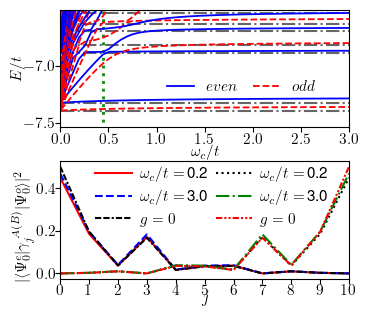

In [13]:
fig, sub = plt.subplots(2,1, figsize=(3.5,3.0))

ltype = ['-b','--r']
linty = ['-r', '--b', ':k', '-.g', ':k', '--k']

groundE = np.min([nocav_ev[0],nocav_od[0]])

jn = 0
for jj in range(jn,jn+16):
    if jj == jn:
        sub[0].plot(arrcomp[::],np.ones(len(arrcomp[::]))*nocav_ev[jj], '-.k', alpha=0.6)
        sub[0].plot(arrcomp[::],np.ones(len(arrcomp[::]))*nocav_od[jj], '-.k', alpha=0.6)
        sub[0].plot(np.ones(17)*(nocav_ev[1]-nocav_ev[0]),np.linspace(1.05*groundE,0.1*groundE,17), ':', 
                    color='green', lw=2.1, alpha=0.9)
        print('gap:',nocav_ev[1]-nocav_ev[0])
    else:
        sub[0].plot(arrcomp[::],np.ones(len(arrcomp[::]))*nocav_ev[jj], '-.k', alpha=0.6)
        sub[0].plot(arrcomp[::],np.ones(len(arrcomp[::]))*nocav_od[jj], '-.k', alpha=0.6)
        
for jj in range(jn,jn+50):
    if jj == jn:
        sub[0].plot(arrcomp[::],Ener_ev[::,jj], ltype[0], label=r'$even$', lw=1.3)
        sub[0].plot(arrcomp[::],Ener_od[::,jj], ltype[1], label=r'$odd$', lw=1.3)
    else:
        sub[0].plot(arrcomp[::],Ener_ev[::,jj], ltype[0], lw=1.3)
        sub[0].plot(arrcomp[::],Ener_od[::,jj], ltype[1], lw=1.3)     

wj = [3,len(arrcomp)-1]


cc, dd = majo_dens(nocav_Vev[::,0],'even',nocav_Vodd[::,0],'odd')

for jj in range(2):

    aa, bb = majo_comp_nw(Vcs_ev[wj[jj],::,0],'even',Vcs_od[wj[jj],::,0],'odd',13)
    psia = np.sum(aa, axis=0)

    sub[1].plot(np.abs(psia[::])**2, linty[jj], 
                label=r'$\omega_c/t=\,$'+str.format('{:.1f}',arrcomp[wj[jj]]))

sub[1].plot(np.abs(np.array(cc))**2, ls=(0, (3, 1, 3, 1,1,1)),
            color='k', label=r'$g=0$') 

for jj in range(2):

    aa, bb = majo_comp_nw(Vcs_ev[wj[jj],::,0],'even',Vcs_od[wj[jj],::,0],'odd',13)
    psib = np.sum(bb, axis=0)
    
    print('omega: ',str(arrcomp[wj[jj]]))
    print('energy even: ',str(Ener_ev[wj[jj],0]))
    print('energy odd: ',str(Ener_od[wj[jj],0]))

    sub[1].plot(np.abs(psib[::])**2, linty[2+jj],
               label=r'$\omega_c/t=\,$'+str.format('{:.1f}',arrcomp[wj[jj]]))

sub[1].plot(np.abs(np.array(dd))**2, ls=(0, (3, 1, 1, 1, 1, 1)),
           color='r',label=r'$g=0$') 


for ii in range(2):
    sub[ii].tick_params(axis='y', pad=0.2)
    sub[ii].tick_params(axis='x', pad=0.5)

sub[0].set_xlim(0,arrcomp[-1])
sub[1].set_xlim(0,n_sites-1)
sub[0].set_ylim(1.02*groundE,0.88*groundE)
sub[0].set_xlabel(r'$\omega_c/t$', x=0.502, labelpad=-1.5)

sub[1].set_xlabel(r'$j$', labelpad=-5.6, fontsize=12)
sub[0].set_ylabel(r'$E/t$',y=0.49, labelpad=-1,)
sub[1].set_ylabel(r'$|\langle \Psi^e_0 |\gamma^{\,A(B)}_j|\Psi^o_0\rangle|^2$',y=0.45, labelpad=1.5)

sub[1].set_xticks(np.linspace(0,n_sites-1,n_sites))    
sub[0].legend(frameon=False, ncols=3, loc=(0.35,0.23), handlelength=1.75, columnspacing=1.0)
sub[1].legend(frameon=False, ncols=2, loc=(0.1,0.39), handlelength=2.4, handletextpad=0.5, columnspacing=0.5)

fig.subplots_adjust(left=0.145, right=0.97, wspace=0.09, hspace=0.29, top=0.988,bottom=0.092)
plt.savefig('EvsFreq_mu0.75_g0.25.pdf')

## Majorana amplitude dependence on cavity frequency

The cell below contains instructions to make figure 7 (2) in the manuscript (appendix).

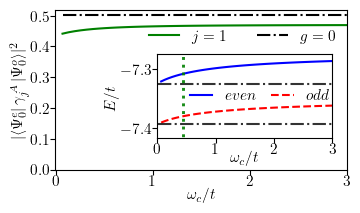

In [14]:
psiall = []
nn = len(arrcomp)
for jj in range(0,nn):
    
    #aa, bb = majo_dens(ground_ev[wj[jj],512*ii:512*(ii+1):,0],'even',ground_od[wj[jj],512*ii:512*(ii+1):,0],'odd')
    aa, bb = majo_comp_nw(Vcs_ev[jj,::,0],'even',Vcs_od[jj,::,0],'odd',15)
    psia = np.sum(aa, axis=0)
    psib = np.sum(bb, axis=0)
    psiall.append(psia)

psiall = np.array(psiall)

cc, dd = majo_dens(nocav_Vev[::,0],'even',nocav_Vodd[::,0],'odd')
majoleft = np.array(cc)

fig, sub = plt.subplots(1, figsize=(3.5,2.0))

sub.plot(arrcomp[1::],np.abs(psiall[1::,0])**2, '-g', label=r'$j=1$')
sub.plot(arrcomp[1::],np.ones(len(arrcomp[1::]))*np.abs(majoleft[0])**2, 
         '-.k', label=r'$g=0$')

#plt.plot(arrcomp[::],np.abs(psiall[::,3])**2, '-', label='j=4')
sub.set_xlim(-0.01,arrcomp[-1])
sub.set_ylim(0.0,0.52)
sub.set_yticks(np.linspace(0,0.5,6))
sub.set_xlabel(r'$\omega_c/t$', labelpad=-1)
sub.set_ylabel(r'$|\langle \Psi^e_0 |\,\gamma^{\,A}_j\,|\Psi^o_0\rangle|^2$',y=0.5, labelpad=1.0)
sub.tick_params(axis='y', pad=0.2)
sub.tick_params(axis='x', pad=0.5)
sub.legend(frameon=False, loc = (0.3,0.75), ncols=2)

axinsub = sub.inset_axes([0.35, 0.2, 0.6, 0.52])
axinsub.set_xlim(0,arrcomp[-1])
groundE = np.min([nocav_ev[0],nocav_od[0]])
axinsub.set_ylim(1.003*groundE,0.984*groundE)
#axinsub.set_yticks(np.linspace(-7.4,-7.28,5))

axinsub.plot(arrcomp[1::],Ener_ev[1::,0], '-b', label=r'$even$')
axinsub.plot(arrcomp[1::],Ener_od[1::,0], '--r', label=r'$odd$')
axinsub.plot(arrcomp[::],np.ones(len(arrcomp[::]))*nocav_ev[0], '-.k', alpha=0.8)
axinsub.plot(arrcomp[::],np.ones(len(arrcomp[::]))*nocav_od[0], '-.k', alpha=0.8) 
axinsub.plot(np.ones(17)*(nocav_ev[1]-nocav_ev[0]),np.linspace(1.1*groundE,0.9*groundE,17), ':', 
            color='green', lw=2.1, alpha=0.9)


axinsub.tick_params(axis='y', pad=0.2)
axinsub.tick_params(axis='x', pad=0.5)
axinsub.set_xlabel(r'$\omega_c/t$', labelpad=-5)
axinsub.set_ylabel(r'$E/t$', rotation='vertical', labelpad=1, y=0.47)
axinsub.legend(frameon=False, loc=(0.15,0.34), ncols=2, columnspacing=1, handlelength=1.5)

fig.subplots_adjust(left=0.135, right=0.97, wspace=0.07, top=0.97,bottom=0.17)
plt.savefig('majo_locdens_freq.pdf')

## Photon probabilities 

The cell below contains instructions to make figure 5 in the manuscript.

omg:  0.1940625
even prob:  [0.96538043 0.03219594 0.00222239]
odd prob:  [0.97109455 0.0270579  0.0016998 ]
omg:  0.1940625
even prob:  [0.08458099 0.85710989 0.05240827]
odd prob:  [0.08324672 0.86778777 0.04444829]
omg:  3.0
even prob:  [9.97049339e-01 2.80864399e-03 1.35335361e-04]
odd prob:  [9.97459347e-01 2.41995127e-03 1.14831379e-04]
omg:  3.0
even prob:  [9.98467612e-01 1.44877698e-03 7.85088541e-05]
odd prob:  [9.95413717e-01 4.48715535e-03 9.20609550e-05]


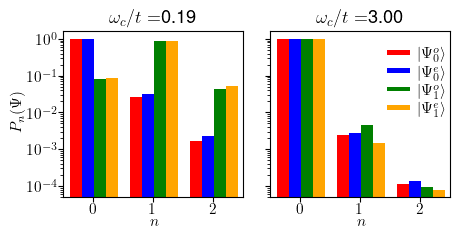

In [15]:
fig, sub = plt.subplots(1,2, figsize=(4.5,2.0), sharex=True, sharey=True)

width = 0.2

colors = ['red','blue','green','orange']
sub_dim_el = 2**(n_sites-1)

for ll in range(2):
    multiplier = -0.4
    ph_prob_pst = []
    for jj in range(0,2):
        print('omg: ',arrcomp[wj[ll]])
    
        ph_prob_ev = np.array([np.sum(np.abs(Vcs_ev[wj[ll],sub_dim_el*ii:sub_dim_el*(ii+1):,jj])**2) for ii in range(3)])
        ph_prob_od = np.array([np.sum(np.abs(Vcs_od[wj[ll],sub_dim_el*ii:sub_dim_el*(ii+1):,jj])**2) for ii in range(3)])
        print('even prob: ',ph_prob_ev)
        print('odd prob: ',ph_prob_od)
        ph_prob_pst.append(ph_prob_od)
        ph_prob_pst.append(ph_prob_ev)
        
    data = {r'$|\Psi_0^{o}\rangle$': ph_prob_pst[0], r'$|\Psi_0^{e}\rangle$': ph_prob_pst[1],
            r'$|\Psi_1^{o}\rangle$': ph_prob_pst[2], r'$|\Psi_1^{e}\rangle$': ph_prob_pst[3]}
    
    x = np.linspace(0,2,3)
    ii = 0
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = sub[ll].bar(x + offset, measurement, width, label=attribute, color=colors[ii])
        #sub[1,1].bar_label(rects, padding=3)
        multiplier += 1
        ii += 1
    
    sub[ll].set_xticks(np.linspace(0+width,2+width,3))
    sub[ll].set_xticklabels([r'$0$',r'$1$',r'$2$'])
    sub[ll].set_xlabel(r'$n$',labelpad=-1.5, x=0.51)
    sub[ll].tick_params(axis='y', pad=0.2)
    sub[ll].tick_params(axis='x', pad=0.5)


sub[0].set_title(r'$\omega_c/t=$'+str.format('{:.2f}',arrcomp[wj[0]]))
sub[1].set_title(r'$\omega_c/t=$'+str.format('{:.2f}',arrcomp[wj[1]]))
sub[0].set_xlim(-0.3,2.7)

sub[0].set_yscale('log')

sub[1].legend(frameon=False, loc=(0.62,0.45), ncols=1, handleheight=0.1, handlelength=1.5, handletextpad=0.5, labelspacing=0.2)

ylbls = [10**(-4),10**(-3),10**(-2),10**(-1),1]
sub[0].set_yticks(np.array(ylbls))
sub[0].set_ylabel(r'$P_{n}(\Psi)$', labelpad=1, y=0.52)

fig.subplots_adjust(left=0.12, right=0.98, wspace=0.15, top=0.98,bottom=0.15)
plt.savefig('photon_probab.pdf')

The cell below contains instructions to make figure 13 (8) in the manuscript (appendix).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.44219339906081334


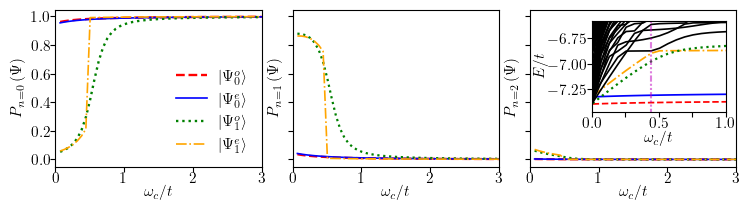

In [16]:
fig, sub = plt.subplots(1,3, figsize=(7.4,2.0), sharey=True)

ll = 0

arrcomp = files[ll].get('w')
Ener_ev = files[ll].get('E_mat_par_even')
Ener_od = files[ll].get('E_mat_par_odd')
Vcs_ev = files[ll].get('V_mat_par_even')
Vcs_od = files[ll].get('V_mat_par_odd')

ttls = [r'$P_{n=0}\,(\Psi)$',r'$P_{n=1}\,(\Psi)$',r'$P_{n=2}\,(\Psi)$']
colors = ['blue','red','orange','green']
lbls = [r'$|\Psi_0^e\rangle$',r'$|\Psi_0^o\rangle$',r'$|\Psi_1^e\rangle$',r'$|\Psi_1^o\rangle$']
lstyles = ['-','--','-.',':']
hstyles = ['--','-',':','-.']

sub_dim_el = 2**(n_sites-1)
mm = len(arrcomp)

for nn in range(2):
    ph_prob_pst = []
    for ll in range(1,mm):
        
        ph_prob_ev = np.array([np.sum(np.abs(Vcs_ev[ll,sub_dim_el*ii:sub_dim_el*(ii+1):,nn])**2) for ii in range(3)])
        ph_prob_od = np.array([np.sum(np.abs(Vcs_od[ll,sub_dim_el*ii:sub_dim_el*(ii+1):,nn])**2) for ii in range(3)])
        ph_prob_pst.append(ph_prob_ev)
        ph_prob_pst.append(ph_prob_od)

    ph_prob_pst = np.array(ph_prob_pst)

    for ii in range(3):
        if ii < 1:
            sub[ii].plot(arrcomp[1::],ph_prob_pst[1::2,ii], ls=hstyles[2*nn], 
                         color=colors[2*nn+1], label=lbls[2*nn+1], lw=1.7)
            sub[ii].plot(arrcomp[1::],ph_prob_pst[0::2,ii], ls=hstyles[2*nn+1], 
                         color=colors[2*nn], label=lbls[2*nn], lw=1.2)
        else:
            sub[ii].plot(arrcomp[1::],ph_prob_pst[1::2,ii], ls=hstyles[2*nn], 
                         color=colors[2*nn+1], lw=1.6)
            sub[ii].plot(arrcomp[1::],ph_prob_pst[0::2,ii], ls=hstyles[2*nn+1], 
                         color=colors[2*nn], lw=1.2)

axin2 = sub[2].inset_axes([0.3, 0.35, 0.65, 0.58])
for jj in range(45):
    if jj < 1:
        axin2.plot(arrcomp[::],Ener_ev[::,jj], ls=lstyles[2*jj], 
                   color=colors[2*jj], lw=1.25)
        axin2.plot(arrcomp[::],Ener_od[::,jj], ls=lstyles[2*jj+1], 
                   color=colors[2*jj+1], lw=1.25)
    elif jj == 1:
        axin2.plot(arrcomp[::],Ener_ev[::,jj], ls=lstyles[2*jj], 
                   color=colors[2*jj], lw=1.25)
        axin2.plot(arrcomp[::],Ener_od[::,jj], ls=lstyles[2*jj+1], 
                   color=colors[2*jj+1], lw=1.6)

    else:
        axin2.plot(arrcomp[::],Ener_ev[::,jj], '-k', lw=1.2)
        axin2.plot(arrcomp[::],Ener_od[::,jj], '-k', lw=1.2)

isogap = nocav_ev[1]-nocav_ev[0]
print(isogap)
axin2.plot(isogap*np.ones(17),np.linspace(-7.5,-6.2,17), 
           ls=(0, (3, 1, 1, 1, 1, 1)), color='m', alpha=0.5)

axin2.tick_params(axis='y', pad=0.2)
axin2.tick_params(axis='x', pad=0.5)
axin2.set_xlim(0,1)
axin2.set_xticks(np.linspace(0,1,5))
axin2.set_xticklabels([r'$0.0$','',r'$0.5$','',r'$1.0$'])
lowEbond = np.min([Ener_ev[0,0],Ener_od[0,0]])
axin2.set_ylim(1.01*lowEbond,0.89*lowEbond)
axin2.set_xlabel(r'$\omega_c/t$',labelpad=-1)
axin2.set_ylabel(r'$E/t$', labelpad=0, y=0.5)

for ii in range(3):
    sub[ii].set_ylabel(ttls[ii])
    sub[ii].legend(frameon=False)
    sub[ii].tick_params(axis='y', pad=0.2)
    sub[ii].tick_params(axis='x', pad=0.5)
    sub[ii].set_xlabel(r'$\omega_c/t$', labelpad=-1)
    sub[ii].set_xlim(0,arrcomp[-1])

sub[0].set_yticks(np.linspace(0,1,6))

fig.subplots_adjust(left=0.065, right=0.985, wspace=0.15, top=0.96,bottom=0.175)
fl_comp = '_g'+str.format('{:.2f}',glist[0])
plt.savefig('Prob_vs_omg_mu0.75_g0.25.pdf')

## More about the many-body energy spectrum

In [17]:
Nlist = [3]
folroot = './data_ED/'
prename = 'Evecs_vs_w_mu0.3_g0.15_ns_'
lstname = '.hdf5'
flist = [folroot+prename+str(nn)+lstname for nn in Nlist]

files = [h5py.File(files,'r') for files in flist]

In [19]:
## Many-body spectrum without cavity

folroot = './data_ED/'
name = 'Evecs_mu0.3_ns_3.hdf5'

file = h5py.File(folroot+name,'r')

nocav_w = file.get('w')
nocav_ev = file.get('E_mat_par_even')
nocav_od = file.get('E_mat_par_odd')

The cell below contains instructions to make figure 6 (1) in the manuscript (appendix).

(49,)
gap: 1.4340158170157395
-1.5839895886657631


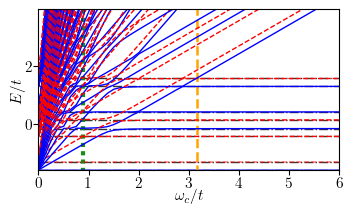

In [20]:
fig, sub = plt.subplots(1, figsize=(3.5,2.0))

groundE = np.min([nocav_ev[0],nocav_od[0]])

for ii, ll in enumerate(range(1)):
    
    arrcomp = files[ll].get('w')
    energy_ev = files[ll].get('E_mat_par_even')
    energy_od = files[ll].get('E_mat_par_odd')
    print(arrcomp.shape)

    for jj in range(2**(Nlist[0]-1)):
        sub.plot(arrcomp[::],np.ones(len(arrcomp))*nocav_ev[jj], 
                 ls='dashdot', color='k', lw=1.0, alpha=0.8)
        sub.plot(arrcomp[::],np.ones(len(arrcomp))*nocav_od[jj], 
                 ls='dashdot', color='k', lw=1.0, alpha=0.8)
    
    sub.plot(np.ones(17)*(nocav_od[1]-nocav_od[0]),np.linspace(1.05*groundE,-2.5*groundE,17), 
                color='green', ls=(0, (1, 1)), lw=3.0, alpha=0.9)
    print('gap:',nocav_ev[1]-nocav_ev[0])

    for jj in range(0,84+200*ii):
        if jj == 0:
            sub.plot(arrcomp[::],energy_ev[::,jj], '-b', lw=1, alpha=0.6)
            sub.plot(arrcomp[::],energy_od[::,jj], '--r', lw=1, alpha=0.6)
            bandwidth = np.min(np.array([energy_ev[0,0],energy_od[0,0]]))
            print(bandwidth)
            sub.plot(-2*bandwidth*np.ones(11),np.linspace(-3.6,7,11), '--', 
                     lw=1.8, color='orange')

        else:
            sub.plot(arrcomp[::],energy_ev[::,jj], '-b', lw=1)
            sub.plot(arrcomp[::],energy_od[::,jj], '--r', lw=1)   

for ii in range(2):
    sub.tick_params(axis='y', pad=0.5)
    sub.tick_params(axis='x', pad=0.8)
    sub.set_xlabel(r'$\omega_c/t$', labelpad=-2)
    #sub[ii].set_xlabel(r'$\omega_c/t$', labelpad=-2, fontsize=14)

sub.set_ylabel(r'$E/t$', rotation='vertical', y=0.49, labelpad=0)
sub.set_xlim(0,arrcomp[-1])
sub.set_ylim(1.01*groundE,-2.5*groundE)

fig.subplots_adjust(left=0.12, right=0.98, wspace=0.18, top=0.97,bottom=0.165)
plt.savefig('replicabands.pdf')